In [1]:
import os
import uproot as ur
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
paths = []

for (path, dirnames, filenames) in os.walk('/home/dmisra/eic/zdc_neutron_samples'):
    paths.extend(os.path.join(path, name) for name in filenames)

In [3]:
samples = {}

for path in paths:
    with ur.open(path) as file:
       tree = file["events"]
       samples[os.path.basename(f'{path}')] = tree.arrays()

In [4]:
def bitExtract(n, k, p):  
    return (((1 << k) - 1)  &  (n >> p))

Multi-Function Pre-Processing Step

In [5]:
def get_labels(data, count):
    energy_labels = []
    for i in range(count):
        index = str(i)
        label = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)
        energy_labels.append(label)
    
    return energy_labels

In [6]:
def sipix_edep(data, count):
    edep = pd.DataFrame(index=np.arange(1,2))
    for i in range(count):
        index = str(i)
        energies = np.array(data['ZDC_SiliconPix_Hits.energy'][i])
        cellID = np.array(data['ZDC_SiliconPix_Hits.cellID'][i])
        layerID = bitExtract(cellID, 6, 8)
        df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
        layers = df.groupby("layerID").sum()
        edep = pd.concat([edep,layers[f'{index}']],axis=1)

    return edep.T.replace(np.NaN,0)

In [7]:
def crystal_edep(data, count):
    edep = pd.DataFrame(index=np.arange(2,3))
    for i in range(count):
        index = str(i)
        energies = np.array(data["ZDCEcalHits.energy"][i])
        cellID = np.array(data["ZDCEcalHits.cellID"][i])
        crystalID = bitExtract(cellID, 12, 10)
        for i in range(len(crystalID)):
            crystalID[i] = 2
        df = pd.DataFrame({f'{index}': energies, 'crystalID': crystalID})
        crystals = df.groupby("crystalID").sum()
        edep = pd.concat([edep,crystals[f'{index}']],axis=1)
        
    return edep.T.replace(np.NaN,0)

In [8]:
def imaging_edep(data, count):
    edep = pd.DataFrame(index=np.arange(3,26))
    for i in range(count):
        index = str(i)
        energies = np.array(data["ZDC_WSi_Hits.energy"][i])
        cellID = np.array(data["ZDC_WSi_Hits.cellID"][i])
        layerID = bitExtract(cellID, 6, 8) + 2
        df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
        layers = df.groupby("layerID").sum()
        edep = pd.concat([edep,layers[f'{index}']],axis=1)
            
    return edep.T.replace(np.NaN,0)

In [9]:
def pbsi_edep(data, count):
    edep = pd.DataFrame(index=np.arange(26,38))
    for i in range(count):
        index = str(i)
        energies = np.array(data["ZDC_PbSi_Hits.energy"][i])
        cellID = np.array(data["ZDC_PbSi_Hits.cellID"][i])
        layerID = bitExtract(cellID, 6, 8) + 25
        df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
        layers = df.groupby("layerID").sum()
        edep = pd.concat([edep,layers[f'{index}']],axis=1)
            
    return edep.T.replace(np.NaN,0)

In [10]:
def pbscint_edep(data, count):
    edep = pd.DataFrame(index=np.arange(38,68))
    for i in range(count):
        index = str(i)
        energies = np.array(data["ZDCHcalHits.energy"][i])
        cellID = np.array(data["ZDCHcalHits.cellID"][i])
        layerID = bitExtract(cellID, 6, 8) + 37
        df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
        layers = df.groupby("layerID").sum()
        edep = pd.concat([edep,layers[f'{index}']],axis=1)
            
    return edep.T.replace(np.NaN,0)

Generate Datasets

In [226]:
sipix_data = pd.concat([sipix_edep(samples[key], 10000) for key in samples])

In [227]:
crystal_data = pd.concat([crystal_edep(samples[key], 10000) for key in samples])

In [228]:
wsi_data = pd.concat([imaging_edep(samples[key], 10000) for key in samples])

In [229]:
pbsi_data = pd.concat([pbsi_edep(samples[key], 10000) for key in samples])

In [230]:
pbscint_data = pd.concat([pbscint_edep(samples[key], 10000) for key in samples])

In [232]:
data_labels = np.concatenate([get_labels(samples[key], 10000) for key in samples])
np.savetxt('/home/dmisra/eic/zdc_data/dnn_labels.csv', data_labels)

In [231]:
data_features = pd.concat([sipix_data, crystal_data, wsi_data, pbsi_data, pbscint_data], axis=1)
data_features.to_csv('/home/dmisra/eic/zdc_data/dnn_features.csv', index=False)

In [235]:
data_features_10GeV = data_features.iloc[0:10000]
data_features_10GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_10GeV.csv', index=False)

data_features_20GeV = data_features.iloc[10000:20000]
data_features_20GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_20GeV.csv', index=False)

data_features_50GeV = data_features.iloc[20000:30000]
data_features_50GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_50GeV.csv', index=False)

data_features_100GeV = data_features.iloc[30000:40000]
data_features_100GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_100GeV.csv', index=False)

data_features_150GeV = data_features.iloc[40000:50000]
data_features_150GeV.to_csv('/home/dmisra/eic/zdc_data/dnn_features_150GeV.csv', index=False)

Load Datasets

In [401]:
data_features = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features.csv')
data_labels = np.loadtxt('/home/dmisra/eic/zdc_data/dnn_labels.csv', delimiter=',')

In [402]:
data_features_10GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_10GeV.csv')
data_features_20GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_20GeV.csv')
data_features_50GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_50GeV.csv')
data_features_100GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_100GeV.csv')
data_features_150GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_150GeV.csv')

(array([1.661e+03, 6.210e+02, 4.330e+02, 4.410e+02, 5.340e+02, 4.660e+02,
        4.540e+02, 4.670e+02, 3.690e+02, 3.330e+02, 3.420e+02, 2.860e+02,
        2.790e+02, 2.510e+02, 2.210e+02, 1.890e+02, 1.670e+02, 1.420e+02,
        1.410e+02, 1.190e+02, 1.250e+02, 9.800e+01, 9.300e+01, 8.200e+01,
        7.500e+01, 7.600e+01, 5.800e+01, 6.400e+01, 5.000e+01, 4.300e+01,
        4.400e+01, 4.300e+01, 4.100e+01, 2.900e+01, 2.000e+01, 2.700e+01,
        2.500e+01, 2.000e+01, 1.700e+01, 1.300e+01, 1.400e+01, 1.200e+01,
        8.000e+00, 6.000e+00, 8.000e+00, 9.000e+00, 9.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 5.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

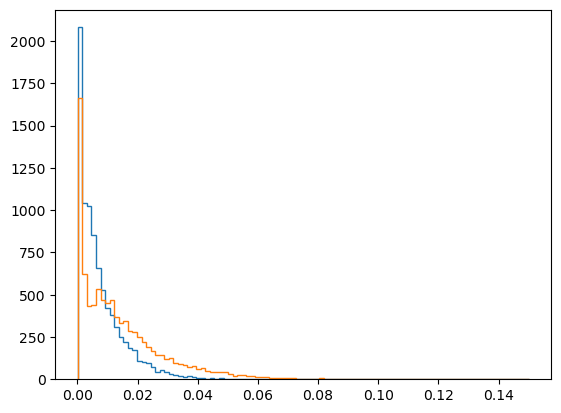

In [92]:
plt.clf()
plt.hist(data_features_50GeV["24"].values, bins=np.linspace(0.0001,0.15,100), histtype="step")
plt.hist(data_features_100GeV["24"].values, bins=np.linspace(0.0001,0.15,100), histtype="step")

Linear Model

In [667]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [668]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.manual_seed(42)

In [669]:
features = torch.from_numpy(data_features.values).float()

labels = torch.from_numpy(data_labels).T.float().unsqueeze(dim=1)

In [670]:
features_10GeV = torch.from_numpy(data_features_10GeV.values).float()
features_20GeV = torch.from_numpy(data_features_20GeV.values).float()
features_50GeV = torch.from_numpy(data_features_50GeV.values).float()
features_100GeV = torch.from_numpy(data_features_100GeV.values).float()
features_150GeV = torch.from_numpy(data_features_150GeV.values).float()

In [671]:
#Split train/test data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [672]:
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [699]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.linear = nn.Linear(in_features=input_shape, out_features=output_shape)
        
    def forward(self,x):
        out = self.linear(x)
        return out

In [700]:
model_1 = Model(input_shape=67, output_shape=1)

In [627]:
custom_weight = torch.zeros(model_1.linear.weight.shape)
custom_weight.shape
custom_bias = torch.Tensor([2.71])

In [628]:
custom_weight[0,0] = 1.77
custom_weight[0,1] = 1.16
custom_weight[0,2:25] = 101.07
custom_weight[0,25:37] = 402.79
custom_weight[0,37:67] = 60.02

In [629]:
model_1.linear.weight = torch.nn.Parameter(custom_weight)
model_1.linear.bias = torch.nn.Parameter(custom_bias)

In [701]:
def custom_loss(output, target):
    loss = torch.mean(((output - target)*target**(-1))**2)
    return loss

In [702]:
learning_rate = 0.001
loss_fn = custom_loss
optimizer = torch.optim.Adam(model_1.parameters(),lr=learning_rate)

In [703]:
#Set number of epochs
epochs = 5000

#Create lists to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    model_1.train()

    for inputs, labels in dataloader:

        ###Training
        y_pred = model_1(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ###Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(x_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")


Epoch: 0 | MSE Train Loss: 0.9343544244766235 | MSE Test Loss: 0.9399679899215698
Epoch: 100 | MSE Train Loss: 0.20886094868183136 | MSE Test Loss: 0.21559862792491913
Epoch: 200 | MSE Train Loss: 0.10699616372585297 | MSE Test Loss: 0.1055600717663765
Epoch: 300 | MSE Train Loss: 0.06780612468719482 | MSE Test Loss: 0.0679076537489891
Epoch: 400 | MSE Train Loss: 0.07235726714134216 | MSE Test Loss: 0.05295732989907265
Epoch: 500 | MSE Train Loss: 0.05515585467219353 | MSE Test Loss: 0.044236477464437485
Epoch: 600 | MSE Train Loss: 0.026815181598067284 | MSE Test Loss: 0.03858155384659767
Epoch: 700 | MSE Train Loss: 0.03793295472860336 | MSE Test Loss: 0.03493398055434227
Epoch: 800 | MSE Train Loss: 0.026415204629302025 | MSE Test Loss: 0.03263762593269348
Epoch: 900 | MSE Train Loss: 0.01765795238316059 | MSE Test Loss: 0.031208526343107224
Epoch: 1000 | MSE Train Loss: 0.07031868398189545 | MSE Test Loss: 0.030320538207888603
Epoch: 1100 | MSE Train Loss: 0.029068170115351677 | M

KeyboardInterrupt: 

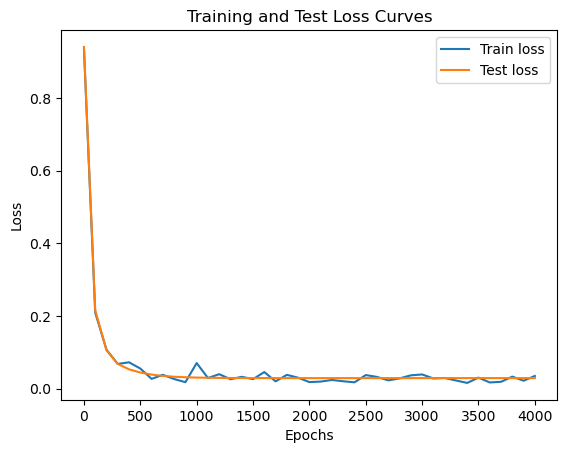

In [704]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

Predictions

In [705]:
from scipy.stats import norm
from scipy.optimize import curve_fit

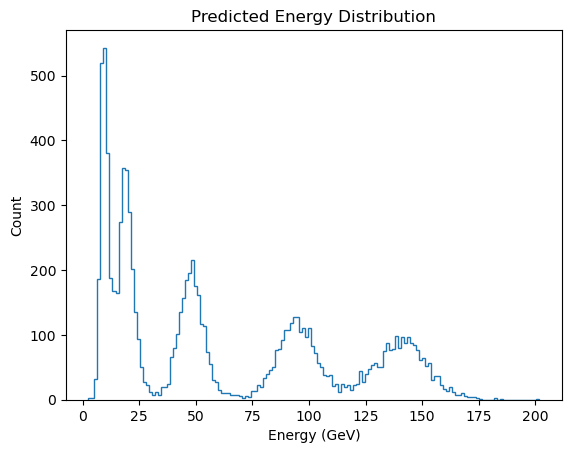

In [706]:
#Set the model in evaluation mode
model_1.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_1(x_test)

plt.hist(y_preds[:,0].numpy(),150,histtype='step')
plt.xlabel('Energy (GeV)')
plt.ylabel('Count')
plt.title('Predicted Energy Distribution')
plt.savefig("dnn_distibution.pdf")

In [707]:
def tensorIntersect(t1, t2):
    a = set((tuple(i) for i in t1.numpy()))
    b = set((tuple(i) for i in t2.numpy()))
    c = a.intersection(b)
    tensorform = torch.from_numpy(np.array(list(c)))

    return tensorform

In [708]:
test_150GeV = tensorIntersect(features_150GeV, x_test)
test_100GeV = tensorIntersect(features_100GeV, x_test)
test_50GeV = tensorIntersect(features_50GeV, x_test)
test_20GeV = tensorIntersect(features_20GeV, x_test)
test_10GeV = tensorIntersect(features_10GeV, x_test)

In [709]:
#Set the model in evaluation mode
model_1.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds_150GeV = model_1(test_150GeV)
  y_preds_100GeV = model_1(test_100GeV)
  y_preds_50GeV = model_1(test_50GeV)
  y_preds_20GeV = model_1(test_20GeV)
  y_preds_10GeV = model_1(test_10GeV)

In [710]:
peak_preds = norm.fit(y_preds_10GeV)[0], norm.fit(y_preds_20GeV)[0], norm.fit(y_preds_50GeV)[0], norm.fit(y_preds_100GeV)[0], norm.fit(y_preds_150GeV)[0]
true_peaks = [10,20,50,100,150]
peak_preds

(10.232771, 19.732288, 48.14091, 94.992065, 140.87253)

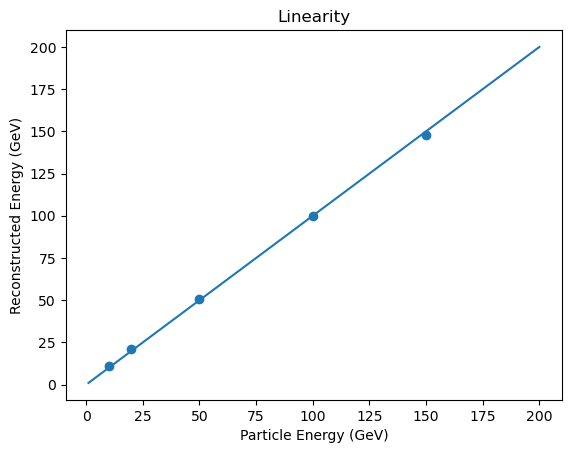

In [694]:
plt.scatter(true_peaks,peak_preds)
plt.xlabel('Particle Energy (GeV)')
plt.ylabel('Reconstructed Energy (GeV)')
plt.plot(np.arange(1,201),np.arange(1,201))
plt.title('Linearity')
plt.savefig("dnn_linearity.pdf")

In [711]:
#Get energy resolution from distribution of predictions
def res(preds,energy):
    return norm.fit(preds)[1]/energy

energy_list = [150,100,50,20,10]
resolutions = res(y_preds_150GeV,150), res(y_preds_100GeV,100), res(y_preds_50GeV,50), res(y_preds_20GeV,20), res(y_preds_10GeV,10)

In [712]:
#Curve fit for energy resolution as a function of energy
def f(E,a,b):
    return np.sqrt((a/np.sqrt(E))**2 + b**2)

popt, pcov = curve_fit(f, energy_list, resolutions)

In [713]:
popt, pcov

(array([0.80860262, 0.05114955]),
 array([[ 3.90517683e-04, -1.06672193e-04],
        [-1.06672193e-04,  7.07872647e-05]]))

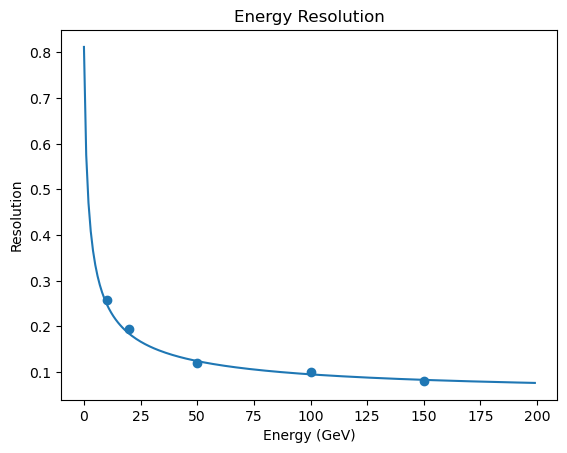

In [644]:
plt.plot(range(200),f(range(1,201),popt[0], popt[1]))
plt.scatter(energy_list,resolutions)
plt.xlabel('Energy (GeV)')
plt.ylabel('Resolution')
plt.title('Energy Resolution')
plt.savefig("dnn_res.pdf")

In [222]:
torch.save(obj=model_1.state_dict(), f="/home/dmisra/eic/model_2")

In [496]:
model_1.load_state_dict(torch.load('/home/dmisra/eic/model_2'))

<All keys matched successfully>

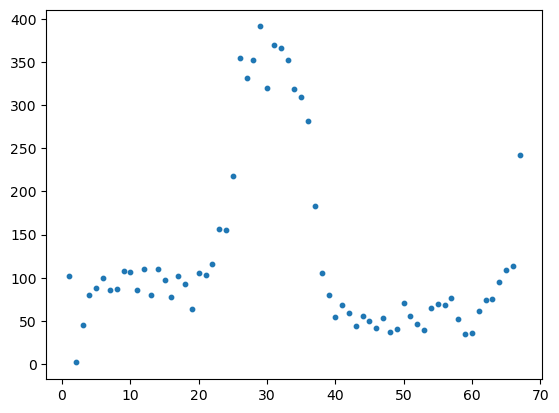

In [714]:
plt.scatter(np.arange(1,68), model_1.state_dict()['linear.weight'][0].numpy(), s=10)

In [717]:
model_1.state_dict()['linear.bias'][0].numpy()

array(1.662299, dtype=float32)